<a href="https://colab.research.google.com/github/forsc/Tryout/blob/main/Churn_pred_RF_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
### Installation of Libs 
#!pip install shap
!pip install pandas-profiling[notebook]

# Loading all the required libraries

In [1]:
# Loading required Data Exploration Packages
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

# Loading Visualization Packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Package to split raw-data into Training and Testing data  
from sklearn.model_selection import train_test_split

# Packages required for Data pre-processing 
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Packages required for training the ML Model 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Reading the dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Importing the dataset
raw_data = pd.read_csv("/content/drive/MyDrive/Churn_Modeling.csv")

# Basic understanding of the dataset and variables

In [6]:
#Snapshot of the first few rows

raw_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasChckng,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619.0,West,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608.0,Central,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502.0,West,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699.0,West,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850.0,Central,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
#Data types of each of the columns 

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      9997 non-null   float64
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasChckng        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [8]:
#Summarization of Descriptive statistics of all the numeric variables 

raw_data.describe()

#Min and Max CreditScore is beyond the given range
#Max value of Age appears to be unrealistic


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasChckng,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,9997.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.496849,38.943500,5.015400,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.708600,10.613726,2.902931,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,305.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.250000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,865.000000,190.000000,30.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [9]:
#Summarization of Descriptive statistics of all the 'Object' variables

raw_data.describe(include = "O")

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,3
top,Smith,West,Male
freq,32,5014,5453


In [10]:
#Calculating the number of missing values for all the variables 

raw_data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        3
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasChckng          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [11]:
#Calculating the number of unique values for all the variables 

raw_data.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          462
Geography              3
Gender                 3
Age                   72
Tenure                12
Balance             6382
NumOfProducts          4
HasChckng              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [12]:
#Printing the records for which CreditScore is missing 

raw_data.loc[~raw_data["CreditScore"].notnull(), ]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasChckng,IsActiveMember,EstimatedSalary,Exited
459,460,15662976,Lettiere,NaN,Central,Male,37,8,0.00,1,1,1,186062.36,0
497,498,15733616,Sopuluchukwu,NaN,West,Male,40,5,80613.93,1,1,1,142838.64,0
625,626,15604119,Alderete,NaN,Central,Male,35,7,110349.82,1,0,0,126355.80,0


In [13]:
#Splitting the dataset to calculate frequency table 

raw_data_numeric_col = raw_data[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']]
raw_data_non_numeric_col = raw_data[['Geography', 'Gender', 'NumOfProducts', 'HasChckng', 'IsActiveMember', 'Exited']]

In [14]:
#Frequency Table of Continuous Variables

for col in raw_data_numeric_col.columns.to_list():
    print("----------------Frequency Table of ", col,"---------------\n" )
    print(raw_data_numeric_col[col].value_counts(bins=5, sort = False))

----------------Frequency Table of  CreditScore ---------------

(304.439, 417.0]      48
(417.0, 529.0]      1117
(529.0, 641.0]      3422
(641.0, 753.0]      3890
(753.0, 865.0]      1520
Name: CreditScore, dtype: int64
----------------Frequency Table of  Age ---------------

(17.826999999999998, 52.4]    8958
(52.4, 86.8]                  1037
(86.8, 121.2]                    4
(121.2, 155.6]                   0
(155.6, 190.0]                   1
Name: Age, dtype: int64
----------------Frequency Table of  Tenure ---------------

(-0.031, 6.0]    6472
(6.0, 12.0]      3527
(12.0, 18.0]        0
(18.0, 24.0]        0
(24.0, 30.0]        1
Name: Tenure, dtype: int64
----------------Frequency Table of  Balance ---------------

(-250.899, 50179.618]       3692
(50179.618, 100359.236]     1533
(100359.236, 150538.854]    3828
(150538.854, 200718.472]     915
(200718.472, 250898.09]       32
Name: Balance, dtype: int64
----------------Frequency Table of  EstimatedSalary ---------------

(-

In [15]:
#Frequency Table of Remaining Variables

for col in raw_data_non_numeric_col.columns.to_list():
    print("----------------Frequency Table of ", col,"---------------\n" )
    print(raw_data_non_numeric_col[col].value_counts())

----------------Frequency Table of  Geography ---------------

West       5014
East       2509
Central    2477
Name: Geography, dtype: int64
----------------Frequency Table of  Gender ---------------

Male       5453
Female     4539
Neutral       8
Name: Gender, dtype: int64
----------------Frequency Table of  NumOfProducts ---------------

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64
----------------Frequency Table of  HasChckng ---------------

1    7055
0    2945
Name: HasChckng, dtype: int64
----------------Frequency Table of  IsActiveMember ---------------

1    5151
0    4849
Name: IsActiveMember, dtype: int64
----------------Frequency Table of  Exited ---------------

0    7963
1    2037
Name: Exited, dtype: int64


In [16]:
#From the above Frequency table we can see that Age, Tenure has some extreme observations
#lets print the top 5 and bottom 5 observations for all the continuous variables
#CreditScore values should also lies between 350 to 850. This will also help us to understand if it has any out of range values or not

for col in raw_data_numeric_col.columns.to_list():
    print("--Top 5 recodes of ", col,"-------\n" )
    print(raw_data_numeric_col[col].nlargest(n=5))
    print("--Bottom 5 recodes of ", col,"-------\n" )
    print(raw_data_numeric_col[col].nsmallest(n=5))
    
# We can see there are few observations which needs our attention:
# 2 values are out of given range of CreditScore - We will have to rectify those
# Tenure has one max value 30 -- 2nd highest is 10. We need to inspect that record for which Tenure is 30


--Top 5 recodes of  CreditScore -------

8      865.0
4      850.0
38     850.0
180    850.0
200    850.0
Name: CreditScore, dtype: float64
--Bottom 5 recodes of  CreditScore -------

90      305.0
1631    350.0
1838    350.0
8723    350.0
8762    350.0
Name: CreditScore, dtype: float64
--Top 5 recodes of  Age -------

27      190
9988    101
6443     92
6759     92
2458     88
Name: Age, dtype: int64
--Bottom 5 recodes of  Age -------

746     18
1619    18
1678    18
2021    18
2136    18
Name: Age, dtype: int64
--Top 5 recodes of  Tenure -------

7     30
12    10
50    10
67    10
79    10
Name: Tenure, dtype: int64
--Bottom 5 recodes of  Tenure -------

29     0
35     0
57     0
72     0
127    0
Name: Tenure, dtype: int64
--Top 5 recodes of  Balance -------

2092    250898.09
3280    238387.56
8733    222267.63
3588    221532.80
6717    216109.88
Name: Balance, dtype: float64
--Bottom 5 recodes of  Balance -------

0     0.0
3     0.0
6     0.0
11    0.0
12    0.0
Name: Balance,

In [17]:
#Dropping first 3 variables as they are not going to add any values to the analysis

raw_data = raw_data.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)

In [21]:
#Generating high level exploratory data analysis report using Pandas-profiling ProfileReport function
#This willl help us to understand the overall picture of the dataset including data distribution across all the variables,
 # interations, Correlation between all the variables, Missing values etc

#profile = ProfileReport(raw_data, title = "Churn Report", explorative = True)
#profile.to_notebook_iframe()


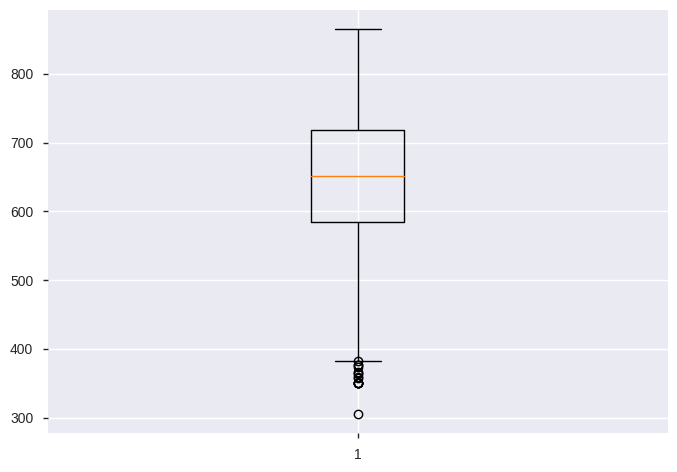

In [22]:
plt.boxplot(raw_data.CreditScore.dropna())
plt.show()

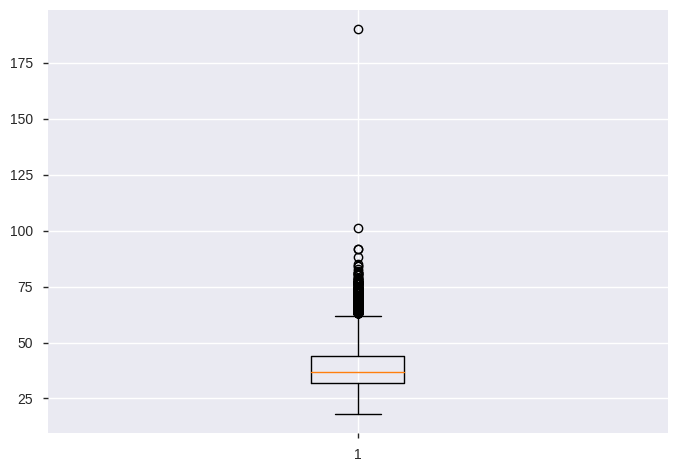

In [23]:
plt.boxplot(raw_data.Age)
plt.show()

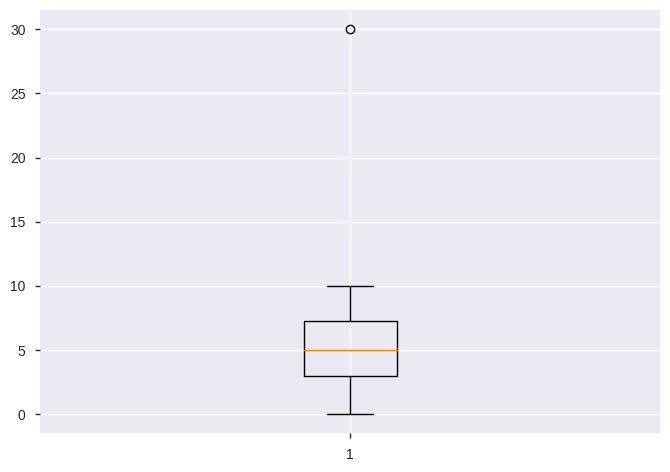

In [24]:
plt.boxplot(raw_data.Tenure)
plt.show()

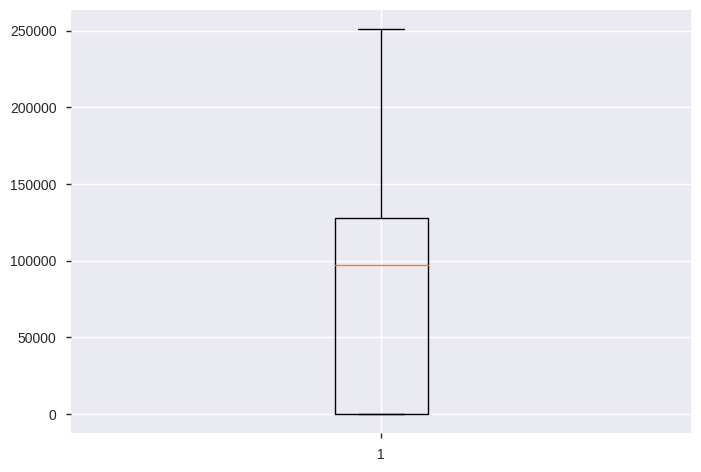

In [25]:
plt.boxplot(raw_data.Balance)
plt.show()

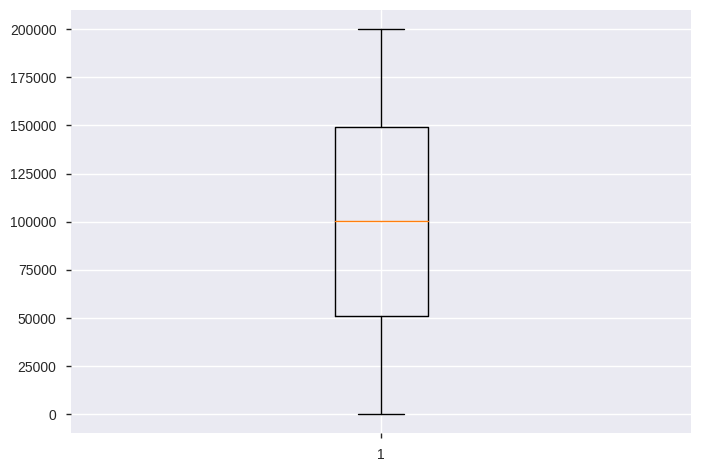

In [26]:
plt.boxplot(raw_data.EstimatedSalary)
plt.show()

# Splitting the dataset into Training and Testing dataset 

In [130]:
# Splitting the data set into training and testing set 
# We are considering 20% data for testing set

X = raw_data.iloc[ : , : -1 ]
Y = raw_data.loc[ : , 'Exited']
x_train, x_test, y_train, y_test = train_test_split(X,Y , test_size = 0.2, random_state = 0)

In [28]:
# Dimension of training set of consists of all the independent variables 

x_train.shape

(8000, 10)

In [29]:
# Dimension of training set of  dependent variable

y_train.shape

(8000,)

In [30]:
# Dimension of testing set of consists of all the independent variables 

x_test.shape

(2000, 10)

In [31]:
# Dimension of testing set of  dependent variable

y_test.shape

(2000,)

In [139]:
x_train

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasChckng,IsActiveMember,EstimatedSalary
7389,667.0,Central,Female,34,5,0.00,2,1,0,163830.64
9275,427.0,East,Male,42,1,75681.52,1,1,1,57098.00
2995,535.0,West,Female,29,2,112367.34,1,1,0,185630.76
5316,654.0,Central,Male,40,5,105683.63,1,1,0,173617.09
356,850.0,Central,Female,57,8,126776.30,2,1,1,132298.49
...,...,...,...,...,...,...,...,...,...,...
9225,594.0,East,Female,32,4,120074.97,2,1,1,162961.79
4859,794.0,Central,Female,22,4,114440.24,1,1,1,107753.07
3264,738.0,West,Male,35,5,161274.05,2,1,0,181429.87
9845,590.0,Central,Female,38,9,0.00,2,1,1,148750.16


# Pre-processing the dataset

In [140]:
# Checking the number of missing values that we have in training set

x_train.isnull().sum()

CreditScore        3
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasChckng          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [141]:
# Replacing all the out of range values of CreditScore
# We will replace all the values greater than 850 by 850 
# We will replace all the values less than 350 by 350 

# Executing the above logic to training data
x_train.loc[x_train.CreditScore > 850 , 'CreditScore'] = 850
x_train.loc[x_train.CreditScore < 350 , 'CreditScore'] = 350

# Executing the above logic to testing data
x_test.loc[x_test.CreditScore > 850 , 'CreditScore'] = 850
x_test.loc[x_test.CreditScore < 350 , 'CreditScore'] = 350


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [142]:
# Record for which Tenure = 30

x_train.loc[x_train.Tenure > 10 , : ]

# Age of this customer is 29 but the tenure is 30 which is contradicting 

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasChckng,IsActiveMember,EstimatedSalary
7,376.0,East,Female,29,30,115046.74,4,1,0,119346.88


In [143]:
# We will replace the values by Missing value and later we will impute it

x_train.loc[x_train.Tenure == 30 , 'Tenure' ] = np.nan
x_test.loc[x_test.Tenure == 30 , 'Tenure' ] = np.nan


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


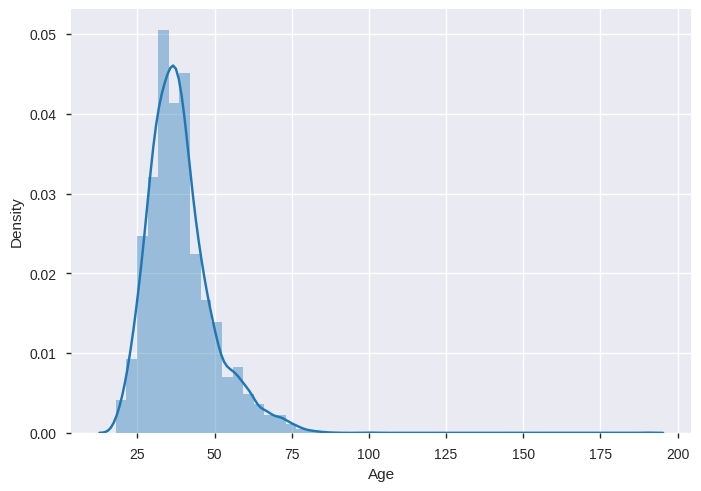

In [144]:
# Distribution plot of Age

sns.distplot(x_train['Age'])


62.0
(278, 10)


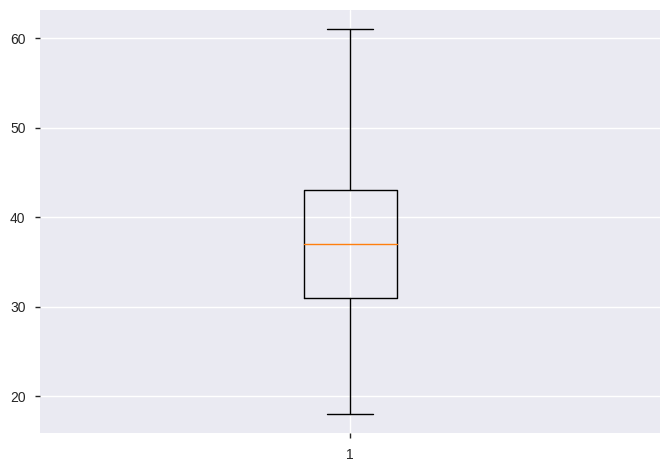

In [145]:
# Checking with different percentile values and based on that we will replace the outliers of Age
# After checking with different percentile values we are replacing all the values which are above 96th percentile with the 96th percentile value
# 96th percentile value of Age from training dataset is 62

percentile = 96
print(np.percentile(x_train['Age'], percentile))
print(x_train.loc[x_train.Age > np.percentile(x_train['Age'], percentile) , : ].shape)
plt.boxplot(x_train.loc[x_train.Age < np.percentile(x_train['Age'], percentile) , : ].Age)
plt.show()



In [146]:
# Executing the above logic for Age in both the training and testing dataset

x_train.loc[x_train.Age > 62 , 'Age'] = 62
x_test.loc[x_test.Age > 62 , 'Age'] = 62


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [147]:
# Creating dummy variables for the categorical variables -- Geography and Gender
# Dropping the first label of each of the categorial valriable to avoid Dummy variale trap

x_train = pd.get_dummies(x_train, drop_first = True)
x_test = pd.get_dummies(x_test, drop_first = True)

# Extracting the cloumns of the datasets and saving it to a list

x_train_col = list(x_train.columns)
x_test_col = list(x_test.columns)

In [148]:
# Imputing all the missing values in our dataset by KNN imputer method 

knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

#Imputing all the missing values of training data using .fit_transform method
x_train_fill = knn_imputer.fit_transform(x_train)

# Applying the same tansformation to testing data
x_test_fill = knn_imputer.transform(x_test)

# Output of these transformation results array. Converting those arrays back to pandas dataframe
x_train = pd.DataFrame(x_train_fill , columns = x_train_col)
x_test = pd.DataFrame(x_test_fill , columns = x_test_col)

In [149]:
# Feature Scaling - STANDERDIZATION
# Feature Scaling using StandardScaler

#ss = StandardScaler()

#x_train.loc[ : , ['CreditScore' , 'Age', 'Tenure', 'NumOfProducts', 'Balance' , 'EstimatedSalary'] ] = ss.fit_transform(x_train.loc[ : , ['CreditScore' , 'Age', 'Tenure', 'NumOfProducts', 'Balance' , 'EstimatedSalary'] ])
#x_test.loc[ : , ['CreditScore' , 'Age', 'Tenure', 'NumOfProducts', 'Balance' , 'EstimatedSalary'] ] = ss.transform(x_test.loc[ : , ['CreditScore' , 'Age', 'Tenure', 'NumOfProducts', 'Balance' , 'EstimatedSalary'] ])


# Feature Scaling - NORMALIZATION
# Feature Scaling using MinMaxScaler

mm = MinMaxScaler()

x_train.loc[ : , ['CreditScore' , 'Age', 'Tenure', 'NumOfProducts', 'Balance' , 'EstimatedSalary'] ] = mm.fit_transform(x_train.loc[ : , ['CreditScore' , 'Age', 'Tenure', 'NumOfProducts', 'Balance' , 'EstimatedSalary'] ])
x_test.loc[ : , ['CreditScore' , 'Age', 'Tenure', 'NumOfProducts', 'Balance' , 'EstimatedSalary'] ] = mm.transform(x_test.loc[ : , ['CreditScore' , 'Age', 'Tenure', 'NumOfProducts', 'Balance' , 'EstimatedSalary'] ])

In [150]:
x_train.shape

(8000, 12)

In [151]:
x_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasChckng,IsActiveMember,EstimatedSalary,Geography_East,Geography_West,Gender_Male,Gender_Neutral
0,0.494,0.386364,0.8,0.549949,0.000000,1.0,1.0,0.964298,1.0,0.0,0.0,0.0
1,0.346,0.500000,0.2,0.431933,0.000000,1.0,0.0,0.643514,0.0,1.0,0.0,0.0
2,0.712,0.545455,0.8,0.400133,0.000000,1.0,1.0,0.378640,0.0,0.0,0.0,0.0
3,0.876,0.318182,0.4,0.470157,0.000000,0.0,0.0,0.446828,0.0,1.0,1.0,0.0
4,0.712,0.454545,0.5,0.683907,0.333333,1.0,1.0,0.678318,1.0,0.0,1.0,0.0


# Model



We will try to find best model from Logistic Regression, Random Forest, SVM , XGBoost.
Firstly, we will try to find best hyperparameters for all these models using GridSearchCV(). 
Then, with those specific hyperparameters we will fit the models and will check different model accuracy parameters.  

In [56]:
###helper function for getting model & AUC
def best_model(model):
    print(model.best_score_)    
    print(model.best_params_)
    print(model.best_estimator_)
def get_auc_scores(y_actual, method,method2):
    auc_score = roc_auc_score(y_actual, method); 
    fpr_df, tpr_df, _ = roc_curve(y_actual, method2); 
    return (auc_score, fpr_df, tpr_df)
def cv_todf(cv_object):
  cv_res_log=pd.DataFrame(cv_object.cv_results_)
  return cv_res_log

In [47]:
#Logistic Regression using GridSearchCV

param_grid = {'C': [0.01,0.1,0.3,0.5,1.0,10.0,20.0], 'max_iter': [100,200,250,500], 'tol':[0.0001,0.00001,0.000001,0.0000001]}

lr_grid = GridSearchCV(LogisticRegression(),param_grid, cv=5)

lr_grid.fit(x_train,y_train)

#Best Parameter and model for Logistic Regression

print(lr_grid.best_params_)
print(lr_grid.best_estimator_)

{'C': 0.1, 'max_iter': 100, 'tol': 0.0001}
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [58]:
##Printing CV results
cv_res_log=cv_todf(lr_grid)

In [61]:
# Random Forest using Grid Serach CV
param_grid = {'max_depth': [5, 6, 7, 8], 'max_features': [2,3,5,6,7,8],'n_estimators':[50,90,100,200],'min_samples_split': [3, 5, 6, 7]}

RF_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)

RF_grid.fit(x_train,y_train)

#Best Parameter and model for Random Forest
cv_res_RF=cv_todf(RF_grid)
print(RF_grid.best_params_)
print(RF_grid.best_estimator_)

{'max_depth': 8, 'max_features': 8, 'min_samples_split': 3, 'n_estimators': 50}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [62]:
# SVM using GridSearchCV

param_grid = {'C': [0.5,100,150], 'gamma': [0.1,0.01,0.001],'probability':[True],'kernel': ['rbf']}

SVM_grid = GridSearchCV(SVC(), param_grid, cv=5)

SVM_grid.fit(x_train,y_train)

#Best Parameter and model for SVM
cv_res_SVM=cv_todf(SVM_grid)
print(SVM_grid.best_params_)
print(SVM_grid.best_estimator_)

{'C': 150, 'gamma': 0.1, 'kernel': 'rbf', 'probability': True}
SVC(C=150, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [63]:
# Linear SVM using GridSearchCV
## KORIS NA, 
param_grid = {'C': [0.5,1,10,50,100,150], 'tol':[0.001,0.0001,0.00001,0.000001]}

Lin_SVM_grid = GridSearchCV(LinearSVC(), param_grid, cv=5)

Lin_SVM_grid.fit(x_train,y_train)

#Best Parameter and model for SVM
cv_res_LINSVM=cv_todf(Lin_SVM_grid)
print(Lin_SVM_grid.best_params_)
print(Lin_SVM_grid.best_estimator_)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

{'C': 10, 'tol': 0.001}
LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
          verbose=0)


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [64]:
# XGBoost using Grid Serach CV

param_grid = {'max_depth': [5,6,7,8], 'gamma': [0.01,0.001],'min_child_weight':[1,5,10], 'learning_rate': [0.01, 0.05,0.1, 0.2, 0.3], 'n_estimators':[5,10,20,80,90,100,500]}

xgb_grid = GridSearchCV(XGBClassifier(), param_grid, cv=5)

xgb_grid.fit(x_train,y_train)

#Best Parameter and model for Random Forest
cv_res_xgb=cv_todf(xgb_grid)
print(xgb_grid.best_params_)
print(xgb_grid.best_estimator_)

{'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 80}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.01,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=80, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


Fitting the best models 

Fitted model performace on training data

WE should consider be aiming to Maximize Recall for 1

In [65]:
# Logistic Regression 

print(classification_report(y_train , lr_grid.best_estimator_.predict(x_train) ))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90      6368
           1       0.69      0.21      0.32      1632

    accuracy                           0.82      8000
   macro avg       0.76      0.59      0.61      8000
weighted avg       0.80      0.82      0.78      8000



In [66]:
# Random Forest 

print(classification_report(y_train , RF_grid.best_estimator_.predict(x_train) ))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      6368
           1       0.87      0.53      0.66      1632

    accuracy                           0.89      8000
   macro avg       0.88      0.75      0.79      8000
weighted avg       0.89      0.89      0.88      8000



In [68]:
# SVM

print(classification_report(y_train , SVM_grid.best_estimator_.predict(x_train) ))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      6368
           1       0.83      0.37      0.52      1632

    accuracy                           0.86      8000
   macro avg       0.84      0.68      0.72      8000
weighted avg       0.85      0.86      0.83      8000



In [69]:
# Linear SVM

print(classification_report(y_train , Lin_SVM_grid.best_estimator_.predict(x_train) ))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90      6368
           1       0.69      0.20      0.31      1632

    accuracy                           0.82      8000
   macro avg       0.76      0.59      0.60      8000
weighted avg       0.80      0.82      0.78      8000



In [70]:
# XGBoost

print(classification_report(y_train , xgb_grid.best_estimator_.predict(x_train) ))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      6368
           1       0.88      0.59      0.71      1632

    accuracy                           0.90      8000
   macro avg       0.89      0.78      0.82      8000
weighted avg       0.90      0.90      0.89      8000



In [72]:
#y = df_train.Exited
#X = df_train.loc[:, df_train.columns != 'Exited']
#X_pol2 = df_train_pol2
lr = lr_grid.best_estimator_
rf = RF_grid.best_estimator_
sv = SVM_grid.best_estimator_
xgb = xgb_grid.best_estimator_

auc_lr, fpr_lr, tpr_lr = get_auc_scores(y_train, lr.predict(x_train),lr.predict_proba(x_train)[:,1])

auc_rf, fpr_rf, tpr_rf = get_auc_scores(y_train, rf.predict(x_train),rf.predict_proba(x_train)[:,1])

auc_sv, fpr_sv, tpr_sv = get_auc_scores(y_train, sv.predict(x_train),sv.predict_proba(x_train)[:,1])

#auc_lin_sv, fpr_lin_sv, tpr_lin_sv = get_auc_scores(y_train, lin_sv.predict(x_train),lin_sv.predict_proba(x_train)[:,1])

auc_xgb, fpr_xgb, tpr_xgb = get_auc_scores(y_train, xgb.predict(x_train),xgb.predict_proba(x_train)[:,1])

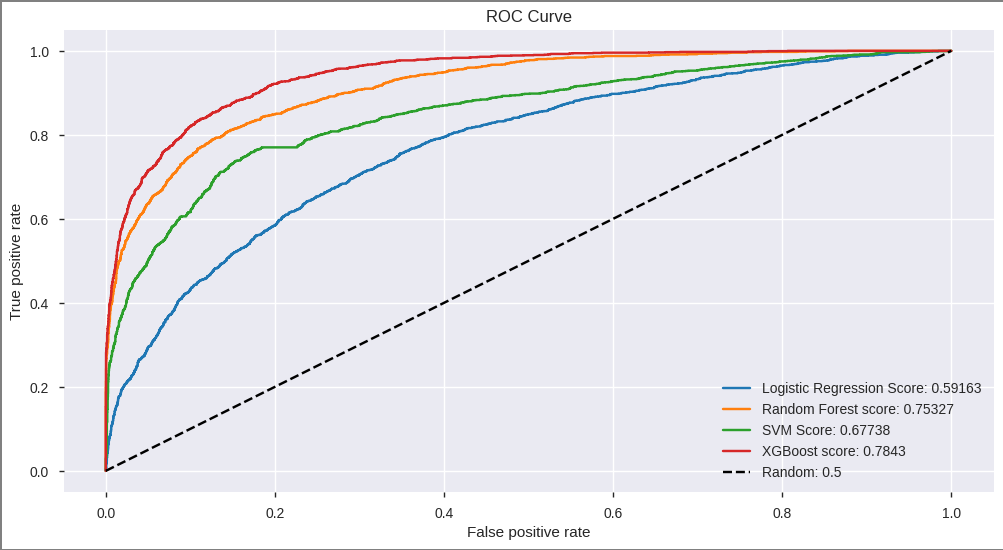

In [73]:
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_lr, tpr_lr, label = 'Logistic Regression Score: ' + str(round(auc_lr, 5)))
plt.plot(fpr_rf, tpr_rf, label = 'Random Forest score: ' + str(round(auc_rf, 5)))
plt.plot(fpr_sv, tpr_sv, label = 'SVM Score: ' + str(round(auc_sv, 5)))
#plt.plot(fpr_lin_sv, tpr_lin_sv, label = 'Linear SVM Score: ' + str(round(auc_lin_sv, 5)))
plt.plot(fpr_xgb, tpr_xgb, label = 'XGBoost score: ' + str(round(auc_xgb, 5)))
plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
#plt.savefig('roc_results_ratios.png')
plt.show()

Based on the Recall value of 1 we should consider Random Forest 

Checking Performance of models on Testing data

In [74]:
print(classification_report(y_test, lr.predict(x_test)))

              precision    recall  f1-score   support

           0       0.83      0.97      0.90      1595
           1       0.67      0.22      0.33       405

    accuracy                           0.82      2000
   macro avg       0.75      0.60      0.62      2000
weighted avg       0.80      0.82      0.78      2000



In [75]:
print(classification_report(y_test, rf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1595
           1       0.73      0.52      0.61       405

    accuracy                           0.86      2000
   macro avg       0.81      0.74      0.76      2000
weighted avg       0.86      0.86      0.86      2000



In [76]:
print(classification_report(y_test, sv.predict(x_test)))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1595
           1       0.83      0.41      0.55       405

    accuracy                           0.86      2000
   macro avg       0.85      0.69      0.73      2000
weighted avg       0.86      0.86      0.84      2000



In [78]:
print(classification_report(y_test, xgb.predict(x_test)))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1595
           1       0.71      0.53      0.61       405

    accuracy                           0.86      2000
   macro avg       0.80      0.74      0.76      2000
weighted avg       0.85      0.86      0.85      2000



In [79]:
auc_lr, fpr_lr, tpr_lr = get_auc_scores(y_test, lr.predict(x_test),lr.predict_proba(x_test)[:,1])

auc_rf, fpr_rf, tpr_rf = get_auc_scores(y_test, rf.predict(x_test),rf.predict_proba(x_test)[:,1])

auc_sv, fpr_sv, tpr_sv = get_auc_scores(y_test, sv.predict(x_test),sv.predict_proba(x_test)[:,1])

#auc_lin_sv, fpr_lin_sv, tpr_lin_sv = get_auc_scores(y_train, lin_sv.predict(x_train),lin_sv.predict_proba(x_train)[:,1])

auc_xgb, fpr_xgb, tpr_xgb = get_auc_scores(y_test, xgb.predict(x_test),xgb.predict_proba(x_test)[:,1])

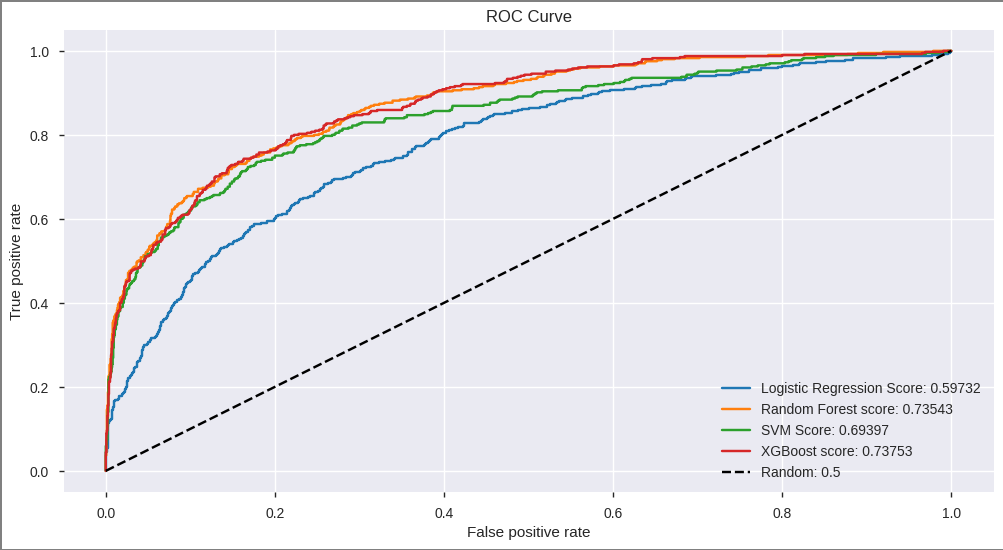

In [80]:
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_lr, tpr_lr, label = 'Logistic Regression Score: ' + str(round(auc_lr, 5)))
plt.plot(fpr_rf, tpr_rf, label = 'Random Forest score: ' + str(round(auc_rf, 5)))
plt.plot(fpr_sv, tpr_sv, label = 'SVM Score: ' + str(round(auc_sv, 5)))
#plt.plot(fpr_lin_sv, tpr_lin_sv, label = 'Linear SVM Score: ' + str(round(auc_lin_sv, 5)))
plt.plot(fpr_xgb, tpr_xgb, label = 'XGBoost score: ' + str(round(auc_xgb, 5)))
plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
#plt.savefig('roc_results_ratios.png')
plt.show()

In [81]:
# Feature Importance
importance = rf.feature_importances_
names = x_train.columns

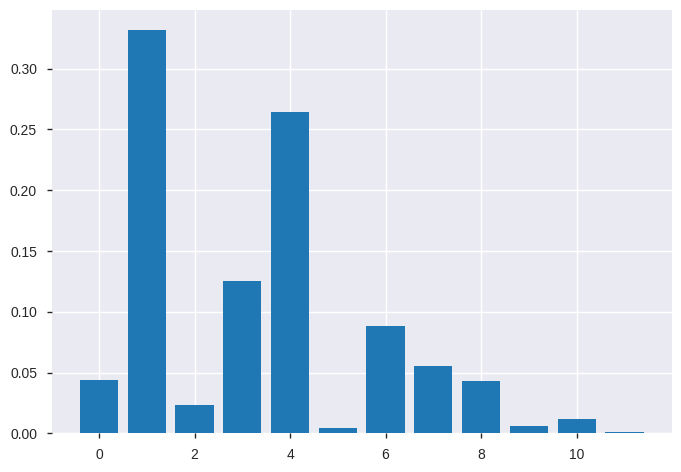

In [89]:
# summarize feature importanc
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [90]:
a = zip(x_train.columns, rf.feature_importances_)

In [91]:
important_features = pd.Series(data=rf.feature_importances_,index=x_train.columns)
important_features.sort_values(ascending=False,inplace=True)

In [92]:
print(important_features)

Age                0.331655
NumOfProducts      0.264518
Balance            0.125598
IsActiveMember     0.088141
EstimatedSalary    0.055684
CreditScore        0.044162
Geography_East     0.043201
Tenure             0.023170
Gender_Male        0.011932
Geography_West     0.006247
HasChckng          0.004449
Gender_Neutral     0.001243
dtype: float64


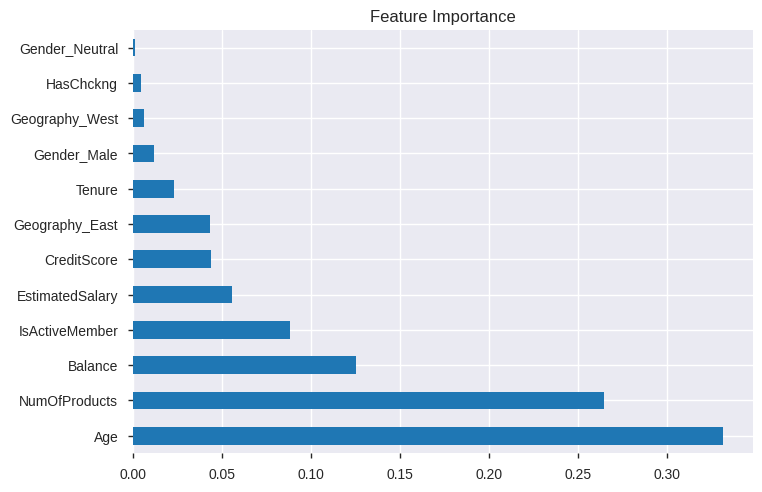

In [93]:
#feat_importances = pd.Series(extraTree.feature_importances_, index=X.columns)
important_features.plot(kind='barh')
plt.title("Feature Importance")
plt.show()

In [94]:
import shap  ##Importing Shaply

In [95]:
explainer = shap.TreeExplainer(rf) ##Explainer defined

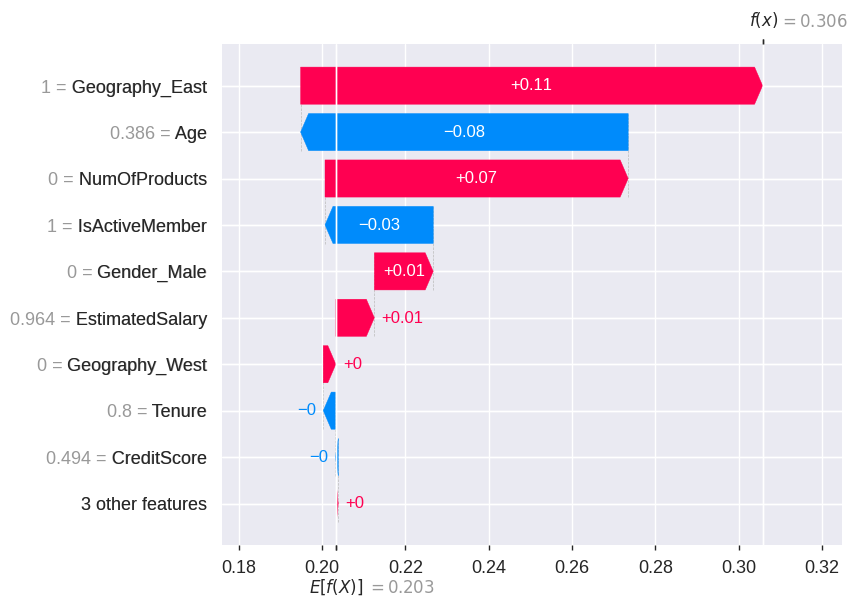

In [116]:
class ShapObject:
    
    def __init__(self, base_values, data, values, feature_names):
        self.base_values = base_values # Single value
        self.data = data # Raw feature values for 1 row of data
        self.values = values # SHAP values for the same row of data
        self.feature_names = feature_names # Column names
        
row = 0
shap_object = ShapObject(base_values = explainer.expected_value[1],
                         values = explainer.shap_values(x_test)[1][row,:],
                         feature_names = x_test.columns,
                         data = x_test.iloc[row,:])

shap.waterfall_plot(shap_object)

In [170]:
choosen_instance = x_test.iloc[[0]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

## Explanation 
basevalue is the the average model E[F(x)] output over the training dataset. where f(x) is the model prediction in this case. Since shap value is based on a game theory concept. the idea about the explanation is how the features are pushing this specific observation to be different than avarage. here biggest push came from Geography and opposite push came from age. The final model decision was a probablity of 0.306

In [172]:
choosen_instance = x_test.iloc[[5]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

The base vaule is 0.2035, where the model prediction is 0.72. The feature value of balance & age and membership made the person highly probable for a churn